In [2]:
%load_ext jupyternotify

import numpy as np
import matplotlib
#allow for latex markup in matplotlib figures
matplotlib.rcParams['text.usetex'] = False
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap


#Import a few utility functions...
import sys  
from pathlib import Path
sys.path.insert(0, "../comm_channel")
sys.path.insert(0, "../polling_systems")
sys.path.insert(0, "../geometry")
sys.path.insert(0, "../utils")

#So we can import my local libs
import CommChannel as CC
import qos
import pointcloud as PC
import TSPN
import PollingSystem as PS
import MarkovianRP as MRP
import dtr
import motion
import shot_solvers as SHOT

import sim_template as sim
from importlib import reload 

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [5]:
#setup quality of service requirements using reasonable values
F5GHz, F2_4GHz = 5, 2.4 #typical wifi frequencies are 2.4, 5, and sometiems 6 GHz
MOBILE_TX_POWER = qos.Pwr(20)#100-200mW (20-23 dBm) pretty typical, with 1W (30dBm) the absolute maximum
print(MOBILE_TX_POWER)
r = 8#any of 2, 4, 6, or 8
rx_noise = qos.Pwr(-85)#based on Yan and MostofiTWC13 #1e-10#
print(rx_noise)
BER = 1e-6
GAMMA_TH = qos.QoSReq(BER, r, rx_noise).thresholdChannelGain(MOBILE_TX_POWER)
print(GAMMA_TH)
print('SNR Threshold: %d'%(GAMMA_TH+MOBILE_TX_POWER.dBm - rx_noise.dBm))

20.000000 dBm	-10.000000 dBW	100.000000 mW	0.100000 W
-85.000000 dBm	-115.000000 dBW	0.000000 mW	0.000000 W
-71.8297512825111
SNR Threshold: 33


In [23]:
#Setup the communication environment:

#For now, use same channel params
nPL = 5.2
kPL = -20

decorrSH = 2.09  
alpha = 16
sigmaSH = np.sqrt(alpha)
psdAtFC = 30

lam = 0.125
kRic = 10
decorrMP = 0.4*lam         
corrMP = 1
#sigmaMP = 3
sigmaMP = 1.5


#12 remote stations
l = 11
qBase = np.array([[2,6],[21,4],
                 [16,11],[28,23],
                 [10,22],[11,39],
                 [30+50, 11+50],[48+50, 8+50],
                 [18+50, 36+50],[35+50, 41+50],
                 [32+50, 33+50],[48+50, 25+50]])

sub_regions = [[25,0,10,0],
               [30,10, 25, 9],
               [20,0, 40, 17],
               [50+50, 25+50, 15+50, 3+50],
               [38+50, 15+50, 45+50, 27+50],
               [50+50, 30+50, 40+50, 20+50]]


x_max = 100
x_min = 0
y_max = 100
y_min = 0
region = [x_max, x_min, y_max, y_min]


cps = [CC.ChannelParams(qBase[i], nPL, kPL, sigmaSH, decorrSH, decorrMP, lam,
                      kRic, corrMP, psdAtFC, sigmaMP) for i in range(len(qBase))]



#res = 2/decorrMP
res = 10
n = 6
p_th = 0.5

#Polling System Setup
bandwidth = 2#leave bandwidth in MHz*1000000#give ourselfes 2MHz of BW
beta = 1/(r*bandwidth)
print(beta)
els = [0.3/beta, 0.2/beta, 0.2/beta, 0.1/beta, 0.05/beta, 0.05/beta]
print(els)

0.0625
[4.8, 3.2, 3.2, 1.6, 0.8, 0.8]


In [12]:
reload(sim)
ccs, cfs, true_joint_con_fields, tjcps = sim.create_channels(cps, region, res, GAMMA_TH, sub_regions)

Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing generation complete.
Generating MP...
MP generation complete.
Generating shadowing...
Shadowing genera

In [13]:
reload(sim)
pcs, pfs, pjcps, prob_pred_con = sim.predict_channels(res, ccs, true_joint_con_fields, GAMMA_TH, p_th=p_th)
trismall_pcs = pcs

print(prob_pred_con)

Drawing 250 samples from Channel 1
Completed PredictedChannel 1
Drawing 250 samples from Channel 2
Completed PredictedChannel 2
Drawing 320 samples from Channel 3
Completed PredictedChannel 3
Drawing 320 samples from Channel 4
Completed PredictedChannel 4
Drawing 460 samples from Channel 5
Completed PredictedChannel 5
Drawing 460 samples from Channel 6
Completed PredictedChannel 6
Drawing 300 samples from Channel 7
Completed PredictedChannel 7
Drawing 300 samples from Channel 8
Completed PredictedChannel 8
Drawing 414 samples from Channel 9
Completed PredictedChannel 9
Drawing 414 samples from Channel 10
Completed PredictedChannel 10
Drawing 400 samples from Channel 11
Completed PredictedChannel 11
Drawing 400 samples from Channel 12
Completed PredictedChannel 12
[0.7965860597439545, 0.801610541727672, 0.5623655913978495, 0.727810650887574, 0.8554502369668247, 0.6361607142857143]


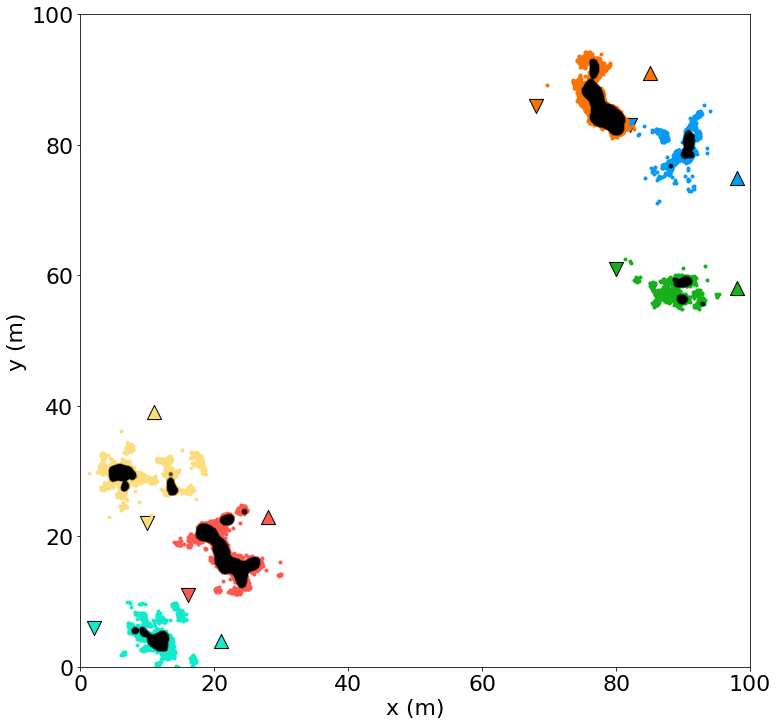

In [14]:
reload(sim)
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.gca().invert_yaxis()
plt.show()

In [41]:
#setup the delay-tolerant relay system
reload(dtr)
dt_sys = dtr.DTR(pcs, region, els, beta, th=GAMMA_TH, p_th = p_th)

Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
9 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
17 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([ 6.5 28.7])  ([ 6.6 28.3]) 
Polygons constructed, looking for holes...
Constructed 4 possibly non-convex polygons
Info: Reduced Poly only contains two points. Reduction ignored
Poly: ([13.4 29.6])  ([13.5 29.6])  ([13.4 29.7]) Is Interior: False
11 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 3 possibly non-convex polygons
6 total subregions
Extracted edges...
No Improvement, orphaned edges exist
PolyConstructor: ([76.4 90.4])  ([76.3 90. ]) 
Polygons constructed, looking for holes...
Constructed 2 possibly non-convex polygons
15 total subregions
Extracted edges...
Polygons constructed, looking for holes...
Constructed 2 p

Total of 60 Permutations to Try
Working on Permutation (0, 1, 2, 3, 4, 5)
Optimal Solution Improved to 241.35
Working on Permutation (0, 1, 2, 3, 5, 4)
Optimal Solution Improved to 233.17
Working on Permutation (0, 1, 2, 4, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 2, 4, 5, 3)
Optimal Solution Improved to 229.02
Working on Permutation (0, 1, 2, 5, 3, 4)
skiping based on lower bound
Working on Permutation (0, 1, 2, 5, 4, 3)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 4, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 2, 5, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 2, 5)
skiping based on lower bound
Working on Permutation (0, 1, 3, 4, 5, 2)
Working on Permutation (0, 1, 3, 5, 2, 4)
skiping based on lower bound
Working on Permutation (0, 1, 3, 5, 4, 2)
Optimal Solution Improved to 227.59
Working on Permutation (0, 1, 4, 2, 3, 5)
skiping based on lower bound
Working on Permutation (0, 1, 4, 2, 5, 3)
skip

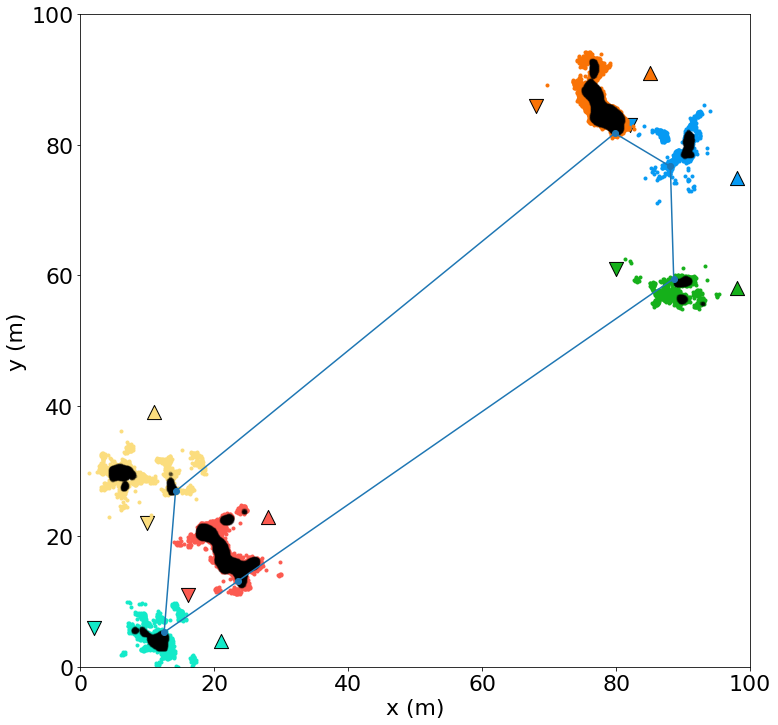

(0, 1, 3, 5, 4, 2)

In [26]:
#Calculate baseline TSPN policy
# import gurobi_solvers as GB
# reload(GB)
# reload(TSPN)
regions = dt_sys.cregions
tspn_min, tspn_argmin = TSPN.TSPN_BF(regions)
x=tspn_argmin[0]

reload(sim)
order = list(tspn_argmin[1])
order.append(0)#complete the loop
sim.plotCFwithOverlay(n, tjcps, pjcps, qBase, region)
plt.plot(x[order,0], x[order,1], zorder=100)
plt.scatter(x[:,0], x[:,1], zorder = 100)
plt.gca().invert_yaxis()
plt.show()

tspn_argmin[1]

In [42]:
reload(dtr)
reload(sim)

vs=[0.5, 1, 2, 5]
AORPS=[]
for v in vs:
    AORPS.append(sim.calc_AORP(dt_sys, v))

    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solver: SHOT\x3a Solved to local optimality
    model.name="unknown";
      - termination condition: optimal
      - message from solv

{'WT': 1830.4237472290913, 'X': array([[12.5       ,  5.30000001],
       [19.2       , 21.60000001],
       [14.2       , 26.89999999],
       [89.29999999, 56.29999999],
       [78.6       , 82.69999999],
       [88.09999999, 76.7       ]]), 'pi': array([0.21535031, 0.33767032, 0.28961276, 0.06640622, 0.04586624,
       0.04509416])}


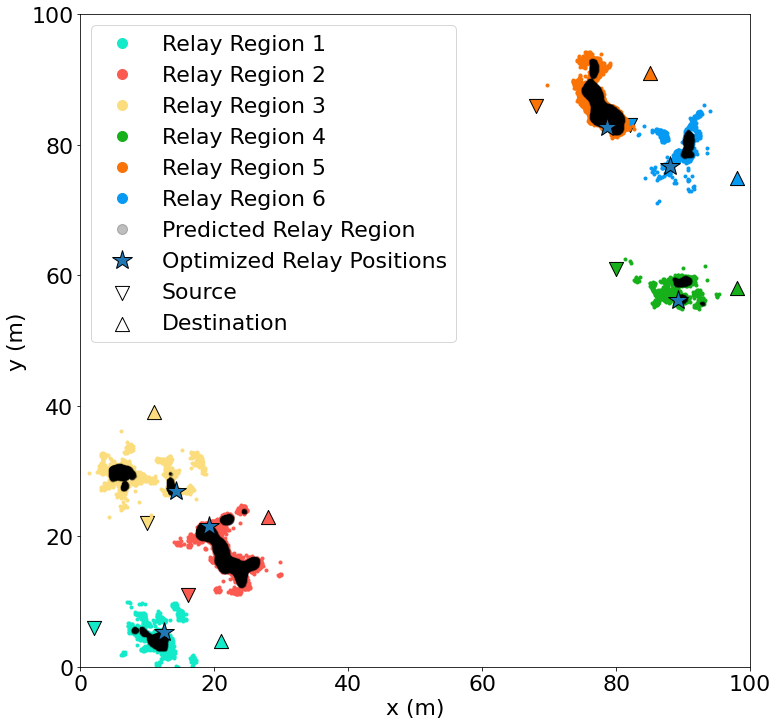

In [25]:
print(AORP)
reload(sim)
sim.plot_AORP(dt_sys, AORP, tjcps, pjcps, qBase, region)

In [27]:
# reload(SHOT)
# pi = AORP['pi']
# x = AORP['X']
# S = np.zeros((n,n))
# for i in range(n):
#     for j in range(n):
#         S[i,j] = np.linalg.norm(x[i] - x[j])

# print(pi)
# print(S)
# P, val = SHOT.min_PWD_over_P(pi, S, verbose = False)


In [43]:
%%notify
reload(sim)
TSPNP={'X':x, 'SEQ':tspn_argmin[1]}

for i in range(len(vs)):
    v = vs[i]
    print('Velocity = %f'%(v))
    AORP = AORPS[i]
    motion_power = motion.LinearMotionPower(7.2, 0.29, v)
    sim.run_sims(ps, AORP, TSPNP, hrs, mins, seconds, motion_power, MOBILE_TX_POWER.W, v)


Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 1724.3999999999996
	Th. WT	WT	E (J)	MBS	MBR
AORP	3660.57	483.47	5340.76	36762.00	15093.55
Tab	---	505.10	5190.39	37638.00	14156.40
TSPN	---	582.04	4888.08	39504.85	12348.65
Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 3020.3999999999996
	Th. WT	WT	E (J)	MBS	MBR
AORP	1826.66	391.97	8040.12	41067.55	10794.00
Tab	---	365.44	7377.85	42457.70	9421.70
TSPN	---	414.93	7071.49	43080.55	8727.30
Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 5612.399999999999
	Th. WT	WT	E (J)	MBS	MBR
AORP	915.35	332.27	12729.22	44073.20	7668.25
Tab	---	300.97	11229.88	45719.60	6155.00
TSPN	---	274.11	10321.43	46676.00	5227.30
Theotretical MB serviced: 51840.0
Theoretical Energy Consumption (J): 13388.399999999996
	Th. WT	WT	E (J)	MBS	MBR
AORP	366.31	200.52	22748.76	47733.75	4134.00
Tab	---	171.58	20870.18	48546.25	3288.25
TSPN	---	140.25	19002.00	49363.25	2460.75
Done


<IPython.core.display.Javascript object>